In [1]:
import torch
from model import ECG_ResNeXt

# Function to process the ECG data before feeding it into the model
def get_inputs(device, ecg_batch, apply="non_zero", signal_crop_len=2560):
    # Process ECG data
    if ecg_batch.shape[1] > ecg_batch.shape[2]:
        ecg_batch = ecg_batch.permute(0, 2, 1)
    B, n_leads, signal_len = ecg_batch.shape

    if apply == "non_zero":
        transformed_ecg = torch.zeros(B, n_leads, signal_crop_len)
        for b in range(B):
            # Infer signal_non_zero_start dynamically for each ECG
            start = torch.nonzero(ecg_batch[b, :, :], as_tuple=False)
            if start.nelement() == 0:
                start = 0
            else:
                start = start[0, 1].item()
            
            end = start + signal_crop_len
            # Adjust start and end if end exceeds signal_len
            if end > signal_len:
                end = signal_len
                start = end - signal_crop_len
                if start < 0:
                    start = 0

            for l in range(n_leads):
                transformed_ecg[b, l, :] = ecg_batch[b, l, start:end]
    else:
        transformed_ecg = ecg_batch

    return transformed_ecg.to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import pandas as pd
import numpy as np
NUMERO_DE_TREINO=50000
# Carregar o arquivo CSV contendo os rótulos
caminho_labels = "../Projeto/Database/ecg_labels.csv"
labels_df = pd.read_csv(caminho_labels)

# Extrair a primeira coluna como ecg_normal_ids
ecg_normal_ids = labels_df['exam_id'].tolist()
ecg_normal_ids= ecg_normal_ids[:NUMERO_DE_TREINO]
# Extrair as colunas de rótulos (1dAVb, RBBB, LBBB, SB, ST, AF) como um vetor Y
# O resultado será uma lista de listas, onde cada sublista contém os rótulos para um exame
Y = labels_df[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].values
Y=Y[:NUMERO_DE_TREINO]
# Caso queira que Y seja um array numpy, você já pode usar o .values para convertê-lo diretamente:
Y = np.array(Y)
print("Número de exam_ids:", len(ecg_normal_ids))
print("Shape de Y:", Y.shape)
import h5py
#X

arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5',
                 ] # Caminhos para os arquivos HDF5

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            # Preencher tracings nulos com epsilon
            return exam_tracings
        
ids_ecgs=ecg_normal_ids


exam_ids_to_cluster = ids_ecgs[:NUMERO_DE_TREINO]  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)




Número de exam_ids: 100000
Shape de Y: (100000, 6)
Número de ecgs que eram pra ser processados: 100000
Número total de traçados processados: 100000


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import f1_score
from tqdm import tqdm  # Importando o tqdm para barra de progresso

# Inicialização do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modelo ECG_ResNeXt e parâmetros
n_classes = 6
num_blocks = 3
channels = [64, 128, 192, 256]
model = ECG_ResNeXt(n_classes=n_classes, num_blocks=num_blocks, channels=channels).to(device)

# Dados de entrada e rótulos (ECG e Classes)
batch_size = 16
signal_len = 4096
n_leads = 12

X = get_inputs(device, X, signal_crop_len=2560)

# Converta X e Y para tensores do PyTorch
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# Ajuste o comprimento da entrada, se necessário
X = get_inputs(device, X, signal_crop_len=2560)

# Divisão dos dados em treino (90%) e teste (10%)
train_size = int(0.9 * len(X))
test_size = len(X) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X, Y), [train_size, test_size])

# DataLoaders para treino e teste
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Definição da função de perda e otimizador
criterion = nn.BCEWithLogitsLoss()  # Multi-label (use CrossEntropyLoss se for multi-class)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loop de treinamento com TQDM
n_epochs = 5  # Ajuste o número de épocas conforme necessário
for epoch in range(n_epochs):
    model.train()  # Modo de treinamento
    train_loss = 0.0

    # Adicionando barra de progresso
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{n_epochs}]", leave=False)

    for ecg_batch, labels in loop:
        ecg_batch, labels = ecg_batch.to(device), labels.to(device)

        # Forward pass
        outputs = model(ecg_batch)
        loss = criterion(outputs, labels)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Atualizando a barra de progresso com o loss médio
        loop.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {train_loss / len(train_loader):.4f}")

/tmp/ipykernel_618519/3391445708.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_618519/3391445708.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


Epoch [1/5], Loss: 1.2469


Epoch [2/5], Loss: 0.1026


Epoch [3/5], Loss: 0.1018


Epoch [4/5], Loss: 0.1018


Epoch [5/5], Loss: 0.1018


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

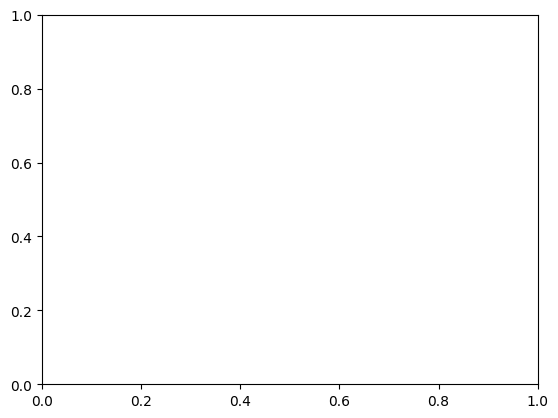

In [21]:
import matplotlib.pyplot as plt
plt.plot(X[1][1])

In [5]:
# Simplified evaluation (no detailed metrics, just accuracy)
model.eval()  # Modo de avaliação
all_preds = []
all_labels = []
with torch.no_grad():  # Desativa cálculo de gradientes para acelerar
    for ecg_batch, labels in test_loader:
        ecg_batch, labels = ecg_batch.to(device), labels.to(device)
        outputs = model(ecg_batch)
        
        # Aplicar sigmoid para transformar os logits em probabilidades
        probabilities = torch.sigmoid(outputs)
        
        # Binarizar as probabilidades usando um limiar de 0.9
        preds = (probabilities > 0.7).int()
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenar todos os tensores de predições e rótulos para avaliação
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calcular o F1-score para multilabel com média por amostra
f1 = f1_score(all_labels, all_preds, average='samples', zero_division=1)
print(f"F1 Score (samples): {f1:.4f}")

# Caminho para salvar o modelo
modelo_path = "ecg_resnext_model.pth"

# Salva os pesos do modelo treinado
torch.save(model.state_dict(), modelo_path)
print(f"Modelo salvo em: {modelo_path}")


F1 Score (samples): 0.8825
Modelo salvo em: ecg_resnext_model.pth


In [6]:
import pandas as pd
import numpy as np

# Carregar o arquivo CSV contendo os rótulos
caminho_labels = "../Projeto/Database/ecg_labels.csv"
labels_df = pd.read_csv(caminho_labels)

# Extrair a primeira coluna como ecg_normal_ids
ecg_normal_ids = labels_df['exam_id'].tolist()
ecg_normal_ids= ecg_normal_ids[5001:5050]
# Extrair as colunas de rótulos (1dAVb, RBBB, LBBB, SB, ST, AF) como um vetor Y
# O resultado será uma lista de listas, onde cada sublista contém os rótulos para um exame
Y_TESTE = labels_df[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].values
Y_TESTE=Y_TESTE[5001:5050]
# Caso queira que Y seja um array numpy, você já pode usar o .values para convertê-lo diretamente:
Y_TESTE = np.array(Y_TESTE)
print("Número de exam_ids:", len(ecg_normal_ids))
print("Shape de Y:", Y_TESTE.shape)
import h5py
#X

arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5'
                 ] # Caminhos para os arquivos HDF5

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            # Preencher tracings nulos com epsilon
            return exam_tracings
        
ids_ecgs=ecg_normal_ids


exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames
# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X_TESTE = np.array(all_tracings)




Número de exam_ids: 49
Shape de Y: (49, 6)
Número de ecgs que eram pra ser processados: 49
Número total de traçados processados: 49


In [20]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize model parameters
n_classes = 6
num_blocks = 3
channels = [64, 128, 192, 256]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the ECG_ResNeXt model and move it to the device
model = ECG_ResNeXt(n_classes=n_classes, num_blocks=num_blocks, channels=channels).to(device)

# Create random ECG signals and labels
batch_size = 16
signal_len = 4096
n_leads = 12
# Supomos que X_TESTE é um np.array com forma (n_samples, n_leads, signal_len)
# Convertendo para tensor e movendo para o dispositivo correto
TESTE_tensor = torch.tensor(X_TESTE, dtype=torch.float32).to(device)
TESTE_tensor = get_inputs(device, TESTE_tensor, signal_crop_len=2560)

# Definindo o modelo (ECG_ResNeXt) e carregando os pesos previamente treinados
model = ECG_ResNeXt(n_classes=n_classes, num_blocks=num_blocks, channels=channels).to(device)
model.load_state_dict(torch.load("ecg_resnext_model.pth"))
model.eval()  # Modo de avaliação

# Realizando previsões sem cálculos de gradientes
with torch.no_grad():
    # Dividindo X_TESTE em lotes (batch_size) para não consumir muita memória
    teste_loader = DataLoader(TESTE_tensor, batch_size=batch_size)
    all_test_preds = []

    for ecg_batch in teste_loader:
        ecg_batch = ecg_batch.to(device)

        # Forward pass
        outputs = model(ecg_batch)
        probabilities = torch.sigmoid(outputs)
        
        # Binarizar as probabilidades usando o mesmo limiar de 0.9
        preds = (probabilities > 0.027).int()
        all_test_preds.append(preds.cpu())

# Concatenando todas as predições para obter as predições finais
all_test_preds = torch.cat(all_test_preds)

# Convertendo para um np.array se necessário
all_test_preds = all_test_preds.numpy()

# Agora, `all_test_preds` contém as predições binarizadas para cada amostra de ECG em `X_TESTE`.
print("Predictions for X_TESTE:", all_test_preds)


Predictions for X_TESTE: [[0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]]


/tmp/ipykernel_618519/272762818.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ecg_resnext_model.pth"))


In [23]:
print(Y_TESTE)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
